In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
from glob import glob
import tables as tb
import tqdm


import multiprocessing as mp

In [3]:
import sys
sys.path.insert(0, 'deeplab/pytorch-deeplab-resnet')
from models import *
from v13_deeplab import *

In [4]:
MODEL_NAME = 'v13'
ORIGINAL_SIZE = 650
sz = 256
num_slice = 9
STRIDE_SZ = 197
PATH = 'data/'
num_workers = 24
num_gpus = 7
bs = 40 * num_gpus 

BASE_DIR = "data/train"
BASE_TEST_DIR = "data/test"
WORKING_DIR = "data/working"

# Restore later
IMAGE_DIR = "data/working/images/{}".format('v12')
# IMAGE_DIR = "data/working/images/{}".format('v5')
V5_IMAGE_DIR = "data/working/images/{}".format('v5')

# ---------------------------------------------------------
# Parameters
MIN_POLYGON_AREA = 30  # 30

# ---------------------------------------------------------
# Input files
FMT_TRAIN_SUMMARY_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("summaryData/{prefix:s}_Train_Building_Solutions.csv"))
FMT_TRAIN_RGB_IMAGE_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TEST_RGB_IMAGE_PATH = str(
    Path(BASE_TEST_DIR) /
    Path("{prefix:s}_Test/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TRAIN_MSPEC_IMAGE_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))
FMT_TEST_MSPEC_IMAGE_PATH = str(
    Path(BASE_TEST_DIR) /
    Path("{prefix:s}_Test/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))

# ---------------------------------------------------------
# Preprocessing result
FMT_RGB_BANDCUT_TH_PATH = IMAGE_DIR + "/rgb_bandcut.csv"
FMT_MUL_BANDCUT_TH_PATH = IMAGE_DIR + "/mul_bandcut.csv"

# ---------------------------------------------------------
# Image list, Image container and mask container
FMT_VALTRAIN_IM_FOLDER = V5_IMAGE_DIR + "/trn_full_rgb/"
FMT_VALTEST_IM_FOLDER = V5_IMAGE_DIR + "/test_full_rgb/"

FMT_VALTRAIN_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_valtrain_ImageId.csv"
FMT_VALTEST_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_valtest_ImageId.csv"
FMT_VALTRAIN_IM_STORE = IMAGE_DIR + "/valtrain_{}_im.h5"
FMT_VALTEST_IM_STORE = IMAGE_DIR + "/valtest_{}_im.h5"
# FMT_VALTRAIN_MASK_STORE = IMAGE_DIR + "/valtrain_{}_mask.h5"
# FMT_VALTEST_MASK_STORE = IMAGE_DIR + "/valtest_{}_mask.h5"
FMT_VALTRAIN_MASK_STORE = V5_IMAGE_DIR + "/valtrain_{}_mask.h5"
FMT_VALTEST_MASK_STORE = V5_IMAGE_DIR + "/valtest_{}_mask.h5"
# FMT_VALTRAIN_MUL_STORE = IMAGE_DIR + "/valtrain_{}_mul.h5"
# FMT_VALTEST_MUL_STORE = IMAGE_DIR + "/valtest_{}_mul.h5"
FMT_VALTRAIN_MUL_STORE = V5_IMAGE_DIR + "/valtrain_{}_mul.h5"
FMT_VALTEST_MUL_STORE = V5_IMAGE_DIR + "/valtest_{}_mul.h5"

FMT_TRAIN_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_train_ImageId.csv"
FMT_TEST_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_test_ImageId.csv"
FMT_TRAIN_IM_STORE = IMAGE_DIR + "/train_{}_im.h5"
FMT_TEST_IM_STORE = IMAGE_DIR + "/test_{}_im.h5"
FMT_TRAIN_MASK_STORE = IMAGE_DIR + "/train_{}_mask.h5"
FMT_TRAIN_MUL_STORE = IMAGE_DIR + "/train_{}_mul.h5"
FMT_TEST_MUL_STORE = IMAGE_DIR + "/test_{}_mul.h5"
FMT_IMMEAN = V5_IMAGE_DIR + "/{}_immean.h5"
FMT_MULMEAN = IMAGE_DIR + "/{}_mulmean.h5"

# ---------------------------------------------------------
# Model files
MODEL_DIR = "data/working/models/{}".format(MODEL_NAME)
FMT_VALMODEL_PATH = MODEL_DIR + "/{}_val_weights.h5"
FMT_FULLMODEL_PATH = MODEL_DIR + "/{}_full_weights.h5"
FMT_VALMODEL_HIST = MODEL_DIR + "/{}_val_hist.csv"
FMT_VALMODEL_EVALHIST = MODEL_DIR + "/{}_val_evalhist.csv"
FMT_VALMODEL_EVALTHHIST = MODEL_DIR + "/{}_val_evalhist_th.csv"

# ---------------------------------------------------------
# Prediction & polygon result
FMT_TESTPRED_PATH = MODEL_DIR + "/{}_pred.h5"
FMT_VALTESTPRED_PATH = MODEL_DIR + "/{}_eval_pred.h5"
FMT_VALTESTPOLY_PATH = MODEL_DIR + "/{}_eval_poly.csv"
FMT_VALTESTTRUTH_PATH = MODEL_DIR + "/{}_eval_poly_truth.csv"
FMT_VALTESTPOLY_OVALL_PATH = MODEL_DIR + "/eval_poly.csv"
FMT_VALTESTTRUTH_OVALL_PATH = MODEL_DIR + "/eval_poly_truth.csv"
FMT_TESTPOLY_PATH = MODEL_DIR + "/{}_poly.csv"
FN_SOLUTION_CSV = "data/output/{}.csv".format(MODEL_NAME)

# ---------------------------------------------------------
# Model related files (others)
FMT_VALMODEL_LAST_PATH = MODEL_DIR + "/{}_val_weights_last.h5"
FMT_FULLMODEL_LAST_PATH = MODEL_DIR + "/{}_full_weights_last.h5"

datapaths = ['data/train/AOI_3_Paris_Train', 'data/train/AOI_2_Vegas_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']

## Preprocessing

In [5]:
# datapaths = ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']
# !python code/v5_im-full_rgb.py preproc_train {datapaths[1]}

In [6]:
# !python code/v5_im-full_rgb.py preproc_train {datapaths[3]}

In [7]:
# !python code/v5_im-full_rgb.py preproc_train {datapaths[0]}
# !python code/v5_im-full_rgb.py preproc_train {datapaths[2]}

In [8]:
# for d in datapaths: print(d, end=' ')

In [9]:
# !parallel python code/v5_im-full_rgb.py preproc_train {} ::: data/train/AOI_2_Vegas_Train data/train/AOI_3_Paris_Train data/train/AOI_4_Shanghai_Train data/train/AOI_5_Khartoum_Train

In [10]:
# for train_path in ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']:
#     !python code/v12_im_deeplab.py preproc_train {train_path}

### Overload

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [12]:
def get_data(area_id, is_test):
    prefix = area_id_to_prefix(area_id)
    fn_train = FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix) if is_test else FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)
    df_train = pd.read_csv(fn_train)
    
    fn_im = FMT_VALTEST_MASK_STORE.format(prefix) if is_test else FMT_VALTRAIN_MASK_STORE.format(prefix)
    y_val = np.zeros((df_train.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 1))
    with tb.open_file(fn_im, 'r') as f:
        for i, image_id in tqdm.tqdm(enumerate(df_train.ImageId.tolist()), total=df_train.shape[0]):
            fn = '/' + image_id
            y_val[i] = np.array(f.get_node(fn))[..., None]
            
    fn_im = FMT_VALTEST_IM_FOLDER if is_test else FMT_VALTRAIN_IM_FOLDER
    X_val = np.zeros((df_train.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 3))
    for i, image_id in tqdm.tqdm(enumerate(df_train.ImageId.tolist()), total=df_train.shape[0]):
        X_val[i] = plt.imread(fn_im + image_id + '.png')[...,:3]
#             print(im.shape)
#         im = np.moveaxis(im, -1, 0)

    X_val, y_val = X_val.astype('float'), y_val.astype('float')
    return X_val, y_val

In [13]:
# memory dataset
def get_dataset(datapath):
    area_id = directory_name_to_area_id(datapath)
    prefix = area_id_to_prefix(area_id)
    trn_x, trn_y = get_data(area_id, False)
#     print(trn_x.shape, trn_y.shape)
#     trn_x = np.moveaxis(trn_x, 1, -1).astype('float') # --> [bs, h, w, ch]
#     trn_y = np.moveaxis(trn_y, 1, -1).astype('float')

#     print(trn_x.shape, trn_y.shape)
    trn_y = np.broadcast_to(trn_y, [trn_y.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 3])

    val_x, val_y = get_data(area_id, True)
#     val_x = val_x[:,:3]
#     val_x = np.moveaxis(val_x, 1, -1).astype('float')
#     val_y = val_y[:,:3]
#     val_y = np.moveaxis(val_y, 1, -1).astype('float')
    val_y = np.broadcast_to(val_y, [val_y.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 3])
               
    return (trn_x,trn_y), (val_x,val_y)


In [14]:
class ArraysSingleDataset(BaseDataset):
    def __init__(self, is_trn, y, transform):
        # input: ch x w x h
        global trn_x, trn_y, val_x, val_y
#         if is_trn:
#             self.x = trn_x; self.y = trn_y
#         else:
#             self.x = val_x; self.y = val_y
        self.is_trn = is_trn
#         self.num_groups = len(x)
        self.sz = trn_x[0].shape[1] if self.is_trn else val_x[0].shape[1]
#         self.ns = np.array([o.shape[0] for o in x])
#         self.cum_ns = np.cumsum(self.ns * num_slice)
        super().__init__(transform)

        
    def get_im(self, i, is_y):
#         idx_file, idx_im = self.get_file_idx(i)
        if is_y:
            im = trn_y[i//num_slice] if self.is_trn else val_y[i//num_slice]
        else:
            im = trn_x[i//num_slice] if self.is_trn else val_x[i//num_slice]
#         slice_pos = idx_im % num_slice
#         a = np.sqrt(num_slice)
#         cut_i = slice_pos // a
#         cut_j = slice_pos % a
#         stride = (self.sz - sz) // a
#         cut_x = int(cut_j * stride)
#         cut_y = int(cut_i * stride)
        slice_pos = i % num_slice
        a = np.sqrt(num_slice)
        cut_i = slice_pos // a
        cut_j = slice_pos % a
        stride = (self.sz - sz) // a
        cut_x = int(cut_j * stride)
        cut_y = int(cut_i * stride)
        return im[cut_x:cut_x + sz, cut_y:cut_y + sz]
        
            
    def get_x(self, i): return self.get_im(i, False)
    def get_y(self, i): return self.get_im(i, True)
        
#     def get_file_idx(self, i):
#         idx_file = np.argmax(i + 1 <= self.cum_ns)
#         if idx_file == 0:
#             idx_im = i
#         else:
#             idx_im = i - self.cum_ns[idx_file - 1]
#         return idx_file, idx_im
    
    def get_n(self): return trn_x.shape[0] * num_slice if self.is_trn else val_x.shape[0] * num_slice
    
    def get_sz(self): return self.sz
        
    def get_c(self): return 1
    def denorm(self, arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
#         return np.clip(self.transform.denorm(np.rollaxis(arr,1,4)), 0, 1)
        return self.transform.denorm(np.rollaxis(arr,1,4))

In [15]:
cut_base = 8
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        c = list(children(self.model.module))
        return [c[:cut_base],
               c[cut_base:]]

In [16]:
def sep_iou(y_pred, y_true, thresh=0.5):
    return np.array([jaccard_coef(p, t) for (p, t) in zip(y_pred, y_true)])
    
## cuda version
# def jaccard_coef(y_pred, y_true, thresh=0.5):
#     smooth = 1e-12
#     y_pred = V(y_pred > thresh).type(torch.cuda.FloatTensor)
#     y_true = V(y_true > thresh).type(torch.cuda.FloatTensor)
#     intersection = y_true * y_pred
#     sum_ = torch.sum(y_true) + torch.sum(y_pred)
#     jac = (intersection + smooth) / (sum_ - intersection + smooth)
#     return torch.mean(jac)

## np version
def jaccard_coef(y_pred, y_true=None, thresh=0.5):
    if isinstance(y_pred, tuple):
        y_pred, y_true = y_pred
    elif y_true is None:
        raise TypeError
        
    smooth = 1e-12
    y_pred = to_np(y_pred) > thresh
    y_true = to_np(y_true) > thresh
    intersection = y_true * y_pred
    sum_ = np.sum(y_true) + np.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return np.mean(jac)

from concurrent.futures import ThreadPoolExecutor
def jaccard_coef_parallel(y_pred, y_true, thresh=0.5, num_workers=8):
    if num_workers == 0:
        return jaccard_coef(y_pred, y_true, thresh=0.5)
    with ThreadPoolExecutor(max_workers=num_workers) as e:
        jac = list(e.map(jaccard_coef, zip(y_pred, y_true)))
        return np.mean(jac)
        

# def jaccard_coef_int(y_true, y_pred):
#     smooth = 1e-12
#     y_true = torch.round(y_true)
#     y_pred_pos = torch.round(torch.clamp(y_pred, 0, 1))
#     intersection = torch.sum(y_true * y_pred_pos)
#     sum_ = torch.sum(y_true + y_pred_pos)
#     jac = (intersection + smooth) / (sum_ - intersection + smooth)
#     return jac.mean()

In [17]:
# t1 = np.zeros((2000,256,256))
# t2 = np.ones((2000,256,256))

In [18]:
# %time jaccard_coef(t1, t2)

In [19]:
# for i in range(1, 24, 2):
#     %time jaccard_coef_parallel(t1, t2, num_workers=i)

num_workers = 8

In [20]:
def get_rgb_mean_stat(area_id):
    prefix = area_id_to_prefix(area_id)

    with tb.open_file(FMT_IMMEAN.format(prefix), 'r') as f:
        im_mean = np.array(f.get_node('/immean'))[:3]
    
    mean = [np.mean(im_mean[i]) for i in range(3)]
    std = [np.std(im_mean[i]) for i in range(3)]
    return np.stack([np.array(mean), np.array(std)])

def get_md_model(datapaths, device_ids=range(num_gpus)):
#     (trn_x, trn_y), (val_x, val_y) = trn, val
    aug_tfms = transforms_top_down
    for o in aug_tfms: o.tfm_y = TfmType.CLASS
        
    area_ids = [directory_name_to_area_id(datapath) for datapath in datapaths]
    stats = np.mean([get_rgb_mean_stat(area_id) for area_id in area_ids], axis=0)
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    
    datasets = ImageData.get_ds(ArraysSingleDataset, (True, True), (False, False), tfms)
    md = ImageData('data', datasets, bs, num_workers=num_workers, classes=None)
    denorm = md.trn_ds.denorm

    if not Path(MODEL_DIR).exists():
        Path(MODEL_DIR).mkdir(parents=True)

    net = to_gpu(UNet16(pretrained='vgg'))
    net = nn.DataParallel(net, device_ids)
    models = UpsampleModel(net)
    return md, models, denorm

def expanded_loss(pred, target):
#     pred = torch.clamp(pred, 0, 1)
    return F.binary_cross_entropy_with_logits(pred[:,0], target)

In [ ]:
(trn_x,trn_y), (val_x,val_y) = (None, None), (None, None)
last_dataset_idx = None
crit=expanded_loss
metrics = jaccard_coef_parallel
def learner_on_dataset(dataset_idx):
    global trn_x, trn_y, val_x, val_y
    global last_dataset_idx
    
    last_dataset_idx = dataset_idx
    (trn_x,trn_y), (val_x,val_y) = get_dataset(datapaths[dataset_idx])
    md, model, denorm = get_md_model([datapaths[dataset_idx]])
    print('Data finished loading')
    learn=ConvLearner(md, model)
    learn.opt_fn=optim.Adam
    learn.crit=crit
    learn.metrics=[metrics]
    return learn, denorm

def learner_on_full_dataset():
    global trn_x, trn_y, val_x, val_y
    
    for datapath in tqdm.tqdm(datapaths):
        (trn_x_l,trn_y_l), (val_x_l,val_y_l) = get_dataset(datapath)
        if trn_x is None:
            (trn_x, trn_y), (val_x, val_y) = (trn_x_l,trn_y_l), (val_x_l,val_y_l)
        else:
            (trn_x, trn_y), (val_x, val_y) = (np.concatenate((trn_x, trn_x_l)), np.concatenate((trn_y, trn_y_l))),\
                (np.concatenate((val_x, val_x_l)), np.concatenate((val_y, val_y_l)))
    del trn_x_l,trn_y_l, val_x_l,val_y_l 
    md, model, denorm = get_md_model([datapaths[dataset_idx]])
    print('Data finished loading')
    learn=ConvLearner(md, model)
    learn.opt_fn=optim.Adam
    learn.crit=crit
    learn.metrics=[metrics]
    return learn, denorm

def load_backup_learn():
    global trn_x, trn_y, val_x, val_y
    global last_dataset_idx
    
    md, model, denorm = get_md_model([datapaths[last_dataset_idx]])
    learn=ConvLearner(md, model)
    learn.opt_fn=optim.Adam
    learn.crit=crit
    learn.metrics=[metrics]
    return learn

In [22]:
def train_and_plot(idx, fn, lrs, epoch=1, wds=None, cycle_len=8, **kwargs):
    kwargs['cycle_len'] = cycle_len
    learn.fit(lrs, epoch, wds, **kwargs)
    plt.subplots(1, 2, figsize=(10, 5))
    plt.tight_layout()
    plt.subplot(121)
    plt.plot(learn.sched.iterations, learn.sched.losses)
    plt.xlabel('loss')
    plt.subplot(122)
    plt.plot(learn.sched.iterations, learn.sched.lrs)
    plt.xlabel('lr')
    learn.save(fn + '_' + str(idx))
    
def after_train_plot():
    plt.subplots(1, 2, figsize=(10, 5))
    plt.tight_layout()
    plt.subplot(121)
    plt.plot(learn.sched.iterations, learn.sched.losses)
    plt.subplot(122)
    plt.plot(learn.sched.iterations, learn.sched.lrs)
    
def bool_pred(pred, thresh=0.5):
    return to_np(pred > thresh)

In [23]:
def plot_worse(tta, shift=0, n_ims=9, is_best=False):
    tta_exp = np.mean(np.exp(tta[0]), axis=0).squeeze()
    ious = sep_iou(tta_exp, tta[1])
    lowest_iou_idx = np.argsort(ious)
    if is_best:
        lowest_iou_idx = np.flip(lowest_iou_idx, 0)
    
    col = 4
    plt.subplots(n_ims, 4, figsize=(15,30))
    
    for i in range(n_ims):
        x, _ = learn.data.fix_dl.get_batch([lowest_iou_idx[i + shift]])
        plt.subplot(n_ims, col, i * col + 1)
        plt.xlabel('rgb')
        plt.imshow(denorm(x)[0])

        plt.subplot(n_ims, col, i * col + 2)
        plt.imshow(tta_exp[lowest_iou_idx[i + shift]])
        plt.xlabel('Prediction: iou = ' + str(ious[lowest_iou_idx[i + shift]]))
        
        plt.subplot(n_ims, col, i * col + 3)
        plt.imshow(bool_pred(tta_exp[lowest_iou_idx[i + shift]], 0.5))
        plt.xlabel('bool_pred')

        plt.subplot(n_ims, col, i * col + 4)
        plt.imshow(tta[1][lowest_iou_idx[i + shift]])
        plt.xlabel('GT')
    plt.tight_layout()

In [ ]:
learn, denorm = learner_on_full_dataset()

 60%|██████    | 1935/3207 [00:54<00:35, 35.59it/s]

In [ ]:
learn.load('autosaved')

In [44]:
learn = load_backup_learn()

In [25]:
!ls data/models

autosaved.h5  tmp.h5	      unfreezed_3.h5  unfreezed_5.h5  unfreezed_7.h5
freezed_1.h5  unfreezed_2.h5  unfreezed_4.h5  unfreezed_6.h5


In [27]:
learn.freeze_to(1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  5%|▍         | 4/87 [00:09<03:10,  2.30s/it, loss=3.66] 


Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   jaccard_coef_parallel    
    0      1.365413   0.485634   0.160035  



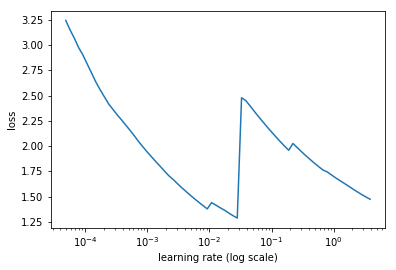

In [28]:
learn.lr_find()
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel     
    0      0.44559    0.244567   0.08276   
    1      0.294687   0.21549    0.067286                  
    2      0.267535   0.219526   0.078148                  
    3      0.27205    0.22089    0.096698                  
    4      0.259657   0.218939   0.084299                  
    5      0.257192   0.236946   0.135721                  
    6      0.257978   0.232302   0.080743                  
    7      0.287926   0.303917   0.129472                  

CPU times: user 4h 39min 18s, sys: 4h 17min 25s, total: 8h 56min 43s
Wall time: 22min 31s


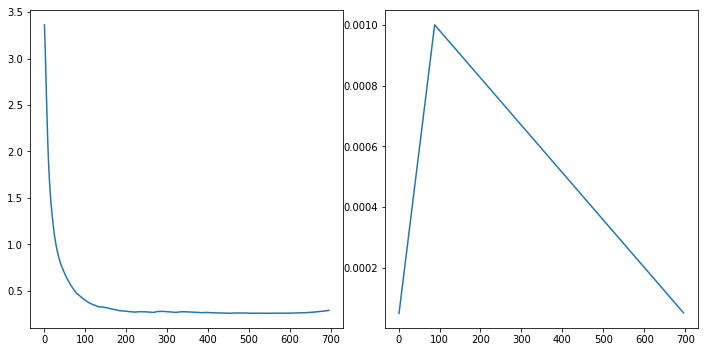

In [31]:
%%time
## Train from scratch, 8 workers
lr = 1e-3
lrs = np.array([lr/3, lr])
wd = 0.025
wds = [wd/10, wd]
train_and_plot(0, 'vegas', epoch=1, lrs=lrs, wds=wds, cycle_len=8, use_clr=(20,8), use_wd_sched=True, best_save_name='autosaved_vegas')

In [33]:
learn.save('vegas_scratch')

In [35]:
learn.load('vegas_scratch')

In [36]:
lr = 1e-4
learn.bn_freeze(False)
lrs = np.array([lr/3, lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel     
    0      0.516417   0.402153   0.098329  
    1      0.343935   0.274751   0.082953                  
    2      0.304925   0.270163   0.079396                  
    3      0.305827   0.285764   0.079011                  
    4      0.320353   0.312601   0.112267                  
    5      0.387376   0.442902   0.158401                  
    6      0.521821   0.586304   0.160035                  
    7      0.622536   0.669193   0.160035                  

CPU times: user 7h 47min 16s, sys: 10h 42min 16s, total: 18h 29min 32s
Wall time: 32min 14s


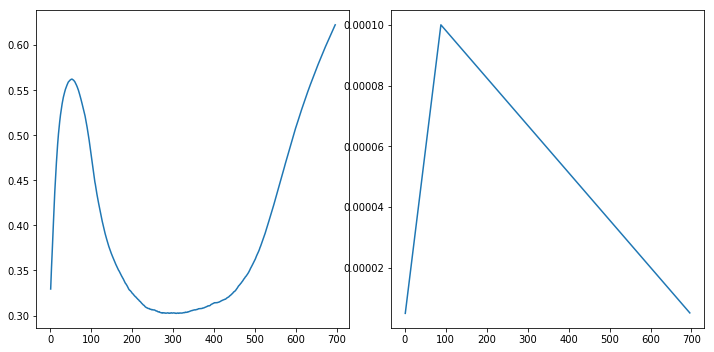

In [37]:
%%time
## Traing with 16 workers
train_and_plot(0, 'vegas', epoch=1, lrs=lrs, wds=wds, cycle_len=8, use_clr=(20,8), use_wd_sched=True, best_save_name='autosaved_vegas')

In [45]:
learn.load('vegas_0')

In [ ]:
%%time
## 24 workers
lr = 1e-5
lrs = np.array([lr/3, lr])
train_and_plot(1, 'vegas', epoch=2, lrs=lrs, wds=wds, use_wd_sched=True, cycle_len=8, use_clr=None, best_save_name='autosaved_2')

HBox(children=(IntProgress(value=0, description='Epoch', max=16), HTML(value='')))

  0%|          | 0/87 [00:00<?, ?it/s]


Exception in thread Thread-15015:
Traceback (most recent call last):
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   jaccard_coef_parallel      
    0      0.686903   0.686665   0.160035  
  0%|          | 0/87 [00:00<?, ?it/s]

In [ ]:
%%time
tta = learn.TTA()

In [ ]:
%%time
tta = learn.TTA()

In [ ]:
%%time
preds = learn.predict()

In [ ]:
plot_worse(tta, shift=3000, n_ims=9)

# Deeplab

In [1]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 2
from learn import *

In [2]:
num_gpus = 4
gpu_start = 4
num_workers = 8
device_ids = range(gpu_start, gpu_start + num_gpus)
torch.cuda.set_device(gpu_start)
bs = 10 * num_gpus

In [3]:
learn, denorm, data = learner_on_dataset(datapaths[1], bs, device_ids, num_workers, model_name='deeplab',
                                         debug=False, global_dataset=True)
(trn_x,trn_y), (val_x,val_y) = data

HBox(children=(IntProgress(value=0, description='ims', max=2695), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1156), HTML(value='')))


Data finished loading: data/train/AOI_2_Vegas_Train


In [8]:
#resume
learn, denorm, data = learner_on_dataset(datapaths[1], bs, device_ids, num_workers, model_name='deeplab',
                                         debug=False, global_dataset=True, data=data)
(trn_x,trn_y), (val_x,val_y) = data

Data finished loading: data/train/AOI_2_Vegas_Train


In [6]:
learn.freeze_to(1)
learn.lr_find()
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/607 [00:00<?, ?it/s]


RuntimeError: element 0 of variables does not require grad and does not have a grad_fn

In [4]:
%%time
lr = 1e-3 / 2
lrs = np.array([lr/9, lr])
wd = 0.025
wds = [wd/9, wd]
learn.freeze_to(1)
train_and_plot(learn, 0, 'deeplab-vegas', lrs=lrs, n_cycles=3, wds=wds, use_wd_sched=False, cycle_len=2, cycle_mult=2, best_save_name='deeplab-vegas')

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

  0%|          | 0/607 [00:00<?, ?it/s]

RuntimeError: element 0 of variables does not require grad and does not have a grad_fn

HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.378657   0.37801    1e-06     
    1      0.347352   0.324806   1e-06                       
    2      0.315907   0.291912   1e-06                       
    3      0.289615   0.352592   1e-06                       
    4      0.273067   0.250963   2e-06                       
 97%|█████████▋| 590/607 [18:27<00:31,  1.88s/it, loss=0.271]    5      0.268496   0.249856   2e-06     
    6      0.258374   0.288052   0.000332                    
    7      0.243523   0.327445   0.138571                    
 46%|████▌     | 278/607 [08:27<10:01,  1.83s/it, loss=0.243]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    10     0.215181   0.269057   0.155929                    
    11     0.212866   0.254074   0.158155                    
    12     0.210433   0.240394   0.158856                    
 46%|████▌     | 278/607 [06:56<08:12,  1.50s/it, loss=0.209]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    16     0.203217   0.597872   0.158897                    
    17     0.192635   0.814432   0.15865                     
    18     0.188896   0.282996   0.147353                    
    19     0.185385   4.533114   0.116431                    
    20     0.180259   0.707025   0.10361                     
 17%|█▋        | 106/607 [02:39<12:32,  1.50s/it, loss=0.178]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    23     0.169872   6.420264   0.161948                    
    24     0.169946   72.604401  0.162731                    
    25     0.164225   20.229185  0.098745                    
    26     0.164172   9.371172   0.109341                    
    27     0.162235   7.559909   0.058712                    
    28     0.159871   8.944091   0.082047                    
    29     0.162729   12.10084   0.023874                    

CPU times: user 3d 16h 32min 11s, sys: 2d 12h 9min 52s, total: 6d 4h 42min 4s
Wall time: 11h 47min 47s


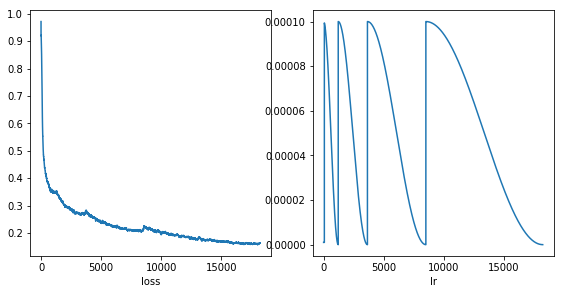

In [5]:
%%time
lr = 1e-4
lrs = np.array([lr/9, lr])
wd = 0.025
wds = [wd/9, wd]
learn.unfreeze()
train_and_plot(learn, 0, 'deeplab-vegas', lrs=lrs, n_cycles=4, wds=wds, use_wd_sched=False,
               cycle_len=2, cycle_mult=2, best_save_name='deeplab-vegas')

In [ ]:
%%time
lr = 1e-4 / 2
lrs = np.array([lr/9, lr])
wd = 0.025
wds = [wd/9, wd]
learn.unfreeze()
train_and_plot(learn, 0, 'deeplab-vegas', lrs=lrs, n_cycles=4, wds=wds, use_wd_sched=True,
               cycle_len=2, cycle_mult=2, best_save_name='deeplab-vegas')

HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.16724    5.742593   0.161536  
    1      0.160605   6.001261   0.164051                    
    2      0.166237   35.061625  0.162525                    
 92%|█████████▏| 557/607 [13:48<01:14,  1.49s/it, loss=0.164]    3      0.161822   0.282629   0.097137  
    4      0.159656   0.785932   0.097261                    
    5      0.156003   0.747153   0.09322                     
    6      0.171056   0.214163   0.113464                    
    7      0.16258    0.316334   0.080068                    
    8      0.162839   0.146672   0.098992                    
    9      0.158199   0.70813    0.060815                    
 97%|█████████▋| 587/607 [14:38<00:29,  1.50s/it, loss=0.153]    10     0.1551     1.23132    0.05933   
    11     0.155144   0.847217   0.073925                    
    12     0.151718   0.484393   0.101714                    
    13     0.152064   1.090048   0.072482                    
 7

In [7]:
def plot_lr_loss(learn, save_name=None):
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    fig.tight_layout()
    ax[0].plot(learn.sched.iterations, learn.sched.losses)
    ax[0].set_xlabel('loss')
    ax[1].plot(learn.sched.iterations, learn.sched.lrs)
    ax[1].set_xlabel('lr')
    if save_name is not None:
        save_path = Path('data/figs')
        if not save_path.exists(): save_path.mkdir(parent=True)
        fig.savefig(str(save_path / Path(save_name)) + '.png')

In [10]:
learn.save('vegas-deeplab2')

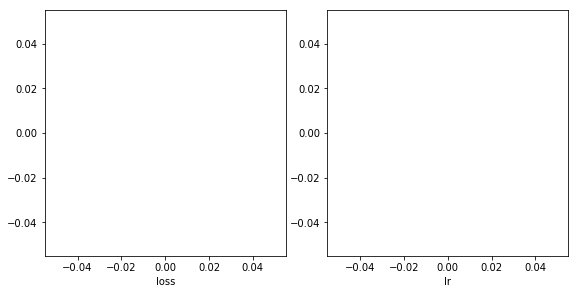

In [8]:
plot_lr_loss(learn, 'vegas-deeplab')

In [3]:
learn, denorm, data = learner_on_dataset(datapaths[2], bs, device_ids, num_workers, model_name='deeplab',
                                         debug=False, global_dataset=True, num_slice=9, sz=256)
(trn_x,trn_y), (val_x,val_y) = data

HBox(children=(IntProgress(value=0, description='ims', max=3207), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1375), HTML(value='')))


Data finished loading: data/train/AOI_4_Shanghai_Train


In [4]:
learn, denorm, data = learner_on_dataset(datapaths[2], bs, device_ids, num_workers, model_name='deeplab',
                                         debug=False, global_dataset=True, data=data, num_slice=9, sz=256)
(trn_x,trn_y), (val_x,val_y) = data

NameError: name 'data' is not defined

In [4]:
def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ, 0.)
learn.metrics=[mask_acc]

HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc                    
    0      0.206264   0.285697   0.930817  
    1      0.18669    0.562764   0.932541                    
    2      0.188747   0.888247   0.938737                    
    3      0.176683   0.333036   0.931994                    
    4      0.171012   3.070413   0.920568                    
 28%|██▊       | 205/722 [05:06<12:53,  1.50s/it, loss=0.17] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    8      0.173465   0.847559   0.941631                    
    9      0.164698   0.144767   0.9472                      
    10     0.15962    0.310504   0.939998                    
 64%|██████▍   | 461/722 [11:33<06:32,  1.50s/it, loss=0.159]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 90%|█████████ | 653/722 [16:17<01:43,  1.50s/it, loss=0.165]    14     0.168236   0.601937   0.941151  
    15     0.161572   0.129493   0.94827                     
    16     0.170449   0.161715   0.942396                    
  7%|▋         | 49/722 [01:14<17:05,  1.52s/it, loss=0.159]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 99%|█████████▉| 718/722 [17:53<00:05,  1.50s/it, loss=0.156]    19     0.155098   0.127132   0.951167  
    20     0.157886   0.135479   0.948155                    
    21     0.152242   0.125819   0.949255                    
  7%|▋         | 49/722 [01:13<16:55,  1.51s/it, loss=0.149] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    24     0.141527   0.167676   0.929055                    
    25     0.142228   0.27359    0.923952                    
    26     0.137253   0.213823   0.933296                    
    27     0.140255   0.232538   0.925686                    
    28     0.141443   0.190565   0.928815                    
    29     0.137828   0.202616   0.93342                     

CPU times: user 4d 7min 45s, sys: 2d 3h 2min 37s, total: 6d 3h 10min 22s
Wall time: 12h 25min 16s


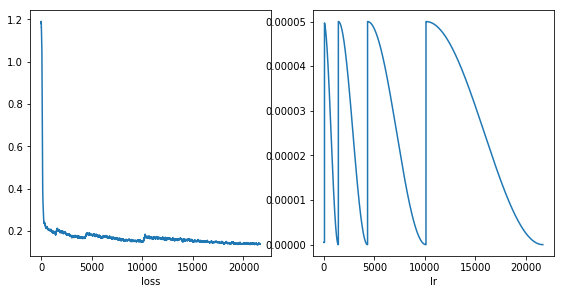

In [5]:
%%time
lr = 1e-4 / 2
lrs = np.array([lr/9, lr])
wd = 0.025
wds = [wd/9, wd]
learn.unfreeze()
train_and_plot(learn, 0, 'deeplab-shanghai', lrs=lrs, n_cycles=4, wds=wds, use_wd_sched=False,
               cycle_len=2, cycle_mult=2, best_save_name='deeplab-shanghai')

In [5]:
learn.load('deeplab-shanghai_0')

In [ ]:
%%time
lr = 1e-4 / 10
lrs = np.array([lr/9, lr])
wd = 0.025
wds = [wd/9, wd]
learn.unfreeze()
train_and_plot(learn, 0, 'deeplab-shanghai-wds', lrs=lrs, n_cycles=4, wds=wds, use_wd_sched=True,
               cycle_len=2, cycle_mult=2, best_save_name='deeplab-shanghai-wds', )

HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc                    
    0      0.140439   0.342181   0.914333  
    1      0.142988   0.20705    0.929338                    
    2      0.14103    0.157853   0.940972                    
    3      0.136932   0.199618   0.92222                     
    4      0.138795   0.208238   0.928036                    
    5      0.137004   0.179805   0.928173                    
    6      0.136114   0.193535   0.921401                    
 18%|█▊        | 127/722 [03:05<14:30,  1.46s/it, loss=0.136]